## Data Exploration

In [1]:

s3_data ="s3://aegovan-data/human_output/human_keyinteractions.json"
s3_annotations ="s3://aegovan-data/input_data_pubtator_annotated.txt"
human_idmapping_dat = "/Users/aeg/Downloads/HUMAN_9606_idmapping.dat"

In [2]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [3]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [4]:
download_single_file(s3_data, data_file)

In [5]:
download_single_file(s3_annotations, annotations_file)

In [6]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [7]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

### Sneak preview of the data

In [8]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)
data["isNegative"] = data.isNegative.isin(['true', '1', 'True'])

In [9]:
data.head(n=3)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract
0,2503510,phosphorylation,False,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."
1,2503513,phosphorylation,False,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}, {'uniprotid': 'Q9BSZ5', 'alias': [['asc_human'], ['Apoptosis-associated speck-like protein containing a CARD'], ['PYD and CARD domain-containing protein'], ['Target of methylation-induced silencing 1'], ['Caspase recruitment domain-containing protein 5'], ['ASC'], ['CARD5'], ['TMS1'], ['PYCARD']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."
10,1796163,phosphorylation,False,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_human'], ['Casein kinase I isoform gamma-2'], ['CK1G2'], ['CSNK1G2']]}, {'uniprotid': 'Q6ZS50', 'alias': [['lrrk2_human'], ['Leucine-rich repeat serine/threonine-protein kinase 2'], ['LRRK2'], ['PARK8'], ['Dardarin']]}]",25500533,None,"LRRK2, a gene relevant to Parkinson's disease,

### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

In [10]:
import matplotlib.pyplot as plt

data.pubmedId.value_counts().hist (bins=50, figsize=(15,5), color = 'red')
plt.title('Papers vs number of interactions distribution')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

<Figure size 1500x500 with 1 Axes>

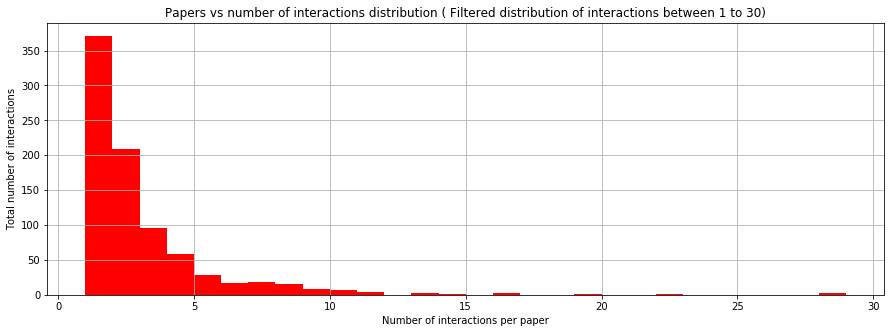

In [11]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of interactions')

plt.show()

### Filter out interactions from paper with more than 15 interactions

In [12]:
pubmed_interaction_count = data.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


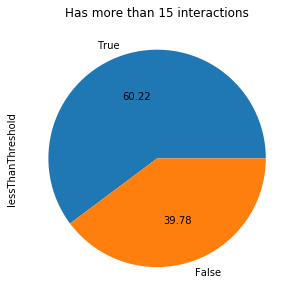

In [13]:
interactions_count= pd.DataFrame()
data["lessThanThreshold"] = data.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


data.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has more than 15 interactions')
plt.show()

In [14]:
data = data.query("lessThanThreshold == 1")

In [15]:
print("Total number of records after filter: {}".format(data.shape[0]))

Total number of records after filter: 2036


### Interaction Types distribution

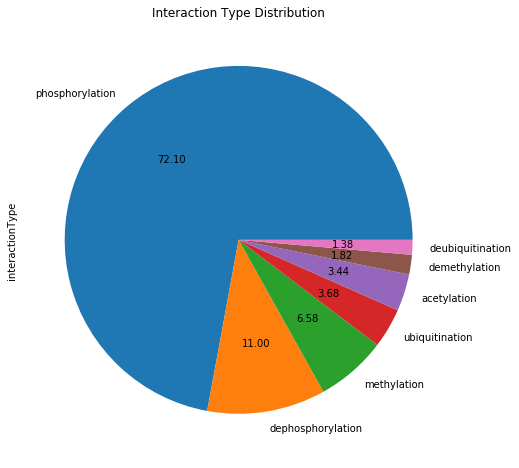

In [16]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(8, 8))
plt.title('Interaction Type Distribution')
plt.savefig("Interactiontype.svg")
plt.show()

In [17]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,1468
dephosphorylation,224
methylation,134
ubiquitination,75
acetylation,70
demethylation,37
deubiquitination,28


### Distinct interaction types per paper

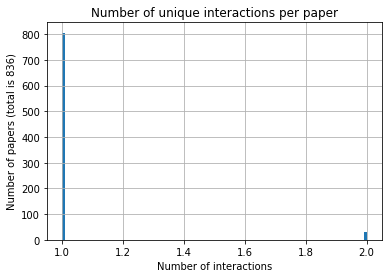

In [18]:
distinct_no_papers = data['pubmedId'].nunique()
data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100)
plt.title("Number of unique interactions per paper")
plt.xlabel('Number of interactions')
plt.ylabel('Number of papers (total is {})'.format(distinct_no_papers))
plt.show()

### Postive vs Negative Relationships

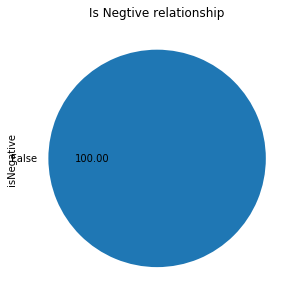

In [19]:
data.isNegative.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Negtive relationship')
plt.show()

### Number of participants per interaction

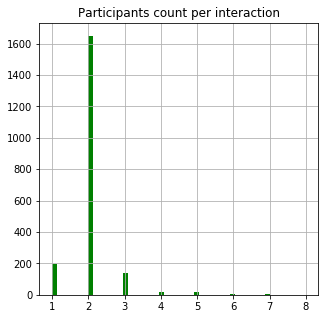

In [20]:
data["participants"].apply(lambda x: len(x)).hist (bins=50, figsize=(5,5), color = 'green')
plt.title("Participants count per interaction")
plt.show()

### Explore if the abstract contains the trigger word

In [21]:
data["hasTriggerWord"] = data.apply(lambda r: r["interactionType"].lower() in r["pubmedabstract"].lower() , 1)

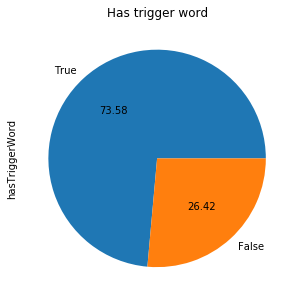

In [22]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

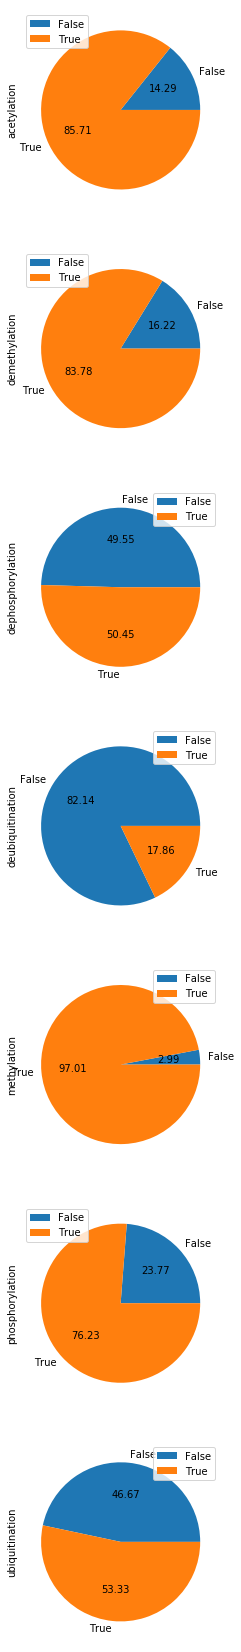

In [23]:
fig, ax = plt.subplots( 7,1, figsize=(45,30))
data.groupby(['hasTriggerWord', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

### Explore how many of the entity alias are mentioned in the abstract

In [24]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

CPU times: user 17.3 s, sys: 154 ms, total: 17.4 s
Wall time: 19.5 s


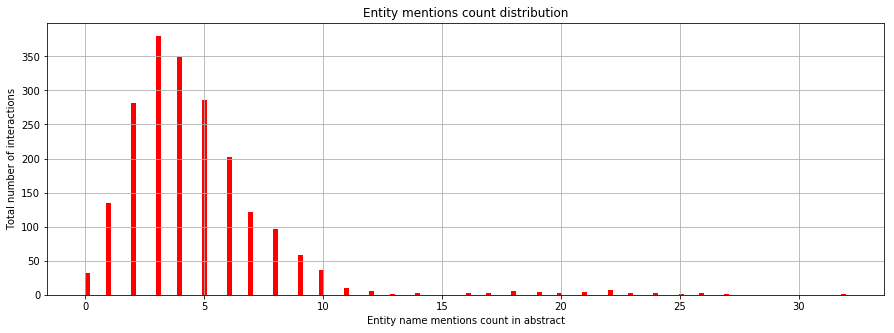

In [25]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

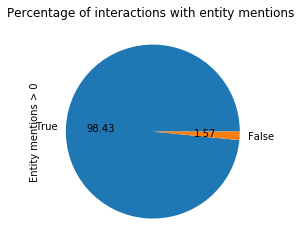

In [26]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [27]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=10)


,participants,pubmedabstract
1683,"[{'uniprotid': 'Q5VYA9', 'alias': [['zic2_human'], ['Zinc finger protein ZIC 2'], ['ZIC2'], ['Zinc finger protein of the cerebellum 2']]}, {'uniprotid': 'Q9UME3', 'alias': [['prkdc_human'], ['DNA-dependent protein kinase catalytic subunit'], ['PRKDC'], ['HYRC'], ['HYRC1'], ['DNPK1'], ['p460']]}]","Signal transducers and activators of transcription (STATs) play a pleomorphic role in signal transduction, similarly to an oncogene. Suppressors of cytokine signaling (SOCS) inhibit STAT pathways. In breast cancer, little is known about the correlation among STATs, SOCS, and clinicopathological/biological features. Therefore, we investigated p-STAT3 (activated form of STAT3) and SOCS-1/3 expression, and clarified their correlation. Immunohistochemical staining for p-STAT3 antigen was performed in 74 surgically resected primary breast cancers. Real-time RT-PCR was used to measure mRNA expression of SOCS-1 and SOCS-3. There were no significant correlations between p-STAT3 expression and clinicopathological/biological features. SOCS-3 mRNA expression in the lymph node-positive group was significantly lower than that in the negative group (p=0.013). Among three groups divided based on the number of involved lymph nodes (node-negative group, 1-3 involved nodes group, 4 or more involved nodes group), the group with 4 or more involved nodes had the lowest expression of SOCS-3 (p=0.043). Correlations were not seen between SOCS-1 and SOCS-3 expression and other clinicopathological/biological features, except for blood vessel invasion. There were no statistical correlations between either SOCS-1 or SOCS-3 mRNA expression and p-STAT3 expression. Reduced expression of SOCS-3 is closely related to lymph node metastasis. Therefore, SOCS-3 may be a good predictor for lymph node metastasis."
2461,"[{'uniprotid': 'D4AA09', 'alias': [['a4gw50_rat'], ['Non-specific serine/threonine protein kinase'], ['Stk38l'], ['rCG_29601']]}]","MICALs (molecules interacting with CasL) are atypical multidomain flavoenzymes with diverse cellular functions. The molecular pathways employed by MICAL proteins to exert their cellular effects remain largely uncharacterized. Via an unbiased proteomics approach, we identify MICAL-1 as a binding partner of NDR (nuclear Dbf2-related) kinases. NDR1/2 kinases are known to mediate apoptosis downstream of the mammalian Ste-20-like kinase MST1, and ablation of NDR1 in mice predisposes the mice to cancer as a result of compromised apoptosis. MST1 phosphorylates NDR1/2 kinases at their hydrophobic motif, thereby facilitating full NDR kinase activity and function. However, if and how this key phosphorylation event is regulated are unknown. Here we show that MICAL-1 interacts with the hydrophobic motif of NDR1/2 and that overexpression or knockdown of MICAL-1 reduces or augments NDR kinase activation or activity, respectively. Surprisingly, MICAL-1 is a phosphoprotein but not an NDR or MST1 substrate. Rather, MICAL-1 competes with MST1 for NDR binding and thereby antagonizes MST1-induced NDR activation. In line with this inhibitory effect, overexpression or knockdown of MICAL-1 inhibits or enhances, respectively, NDR-dependent proapoptotic signaling induced by extrinsic stimuli. Our findings unveil a previously unknown biological role for MICAL-1 in apoptosis and define a novel negative regulatory mechanism of MST-NDR signaling."
1899,"[{'uniprotid': 'Q81755', 'alias': [['polg_hcvja'], ['Genome polyprotein']]}, {'uniprotid': 'P97634', 'alias': [['kc1a_rat'], ['Casein kinase I isoform alpha'], ['Csnk1a1'], ['CK1']]}]",Hepatitis C virus (HCV) NS5A phosphoprotein is a component of virus replicase. Here we demonstrate that in vitro unphosphorylated NS5A protein inhibits HCV RNA-dependent RNA polymerase (RdRp) activity in polyA-oligoU system but has little effect on synthesis of viral RNA. The phosphorylated casein kinase (CK) II NS5A protein causes the opposite effect on RdRp in each of these systems. The p

In [28]:
data.head(n=10)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract,lessThanThreshold,hasTriggerWord,entityMentionsCount
0,2503510,phosphorylation,False,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True,True,1
1,2503513,phosphorylation,False,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}, {'uniprotid': 'Q9BSZ5', 'alias': [['asc_human'], ['Apoptosis-associated speck-like protein containing a CARD'], ['PYD and CARD domain-containing protein'], ['Target of methylation-induced silencing 1'], ['Caspase recruitment domain-containing protein 5'], ['ASC'], ['CARD5'], ['TMS1'], ['PYCARD']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True,True,2
10,1796163,phosphorylation,False,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_human'], ['Casein kinase I isoform gamma-2'], ['CK1G2'], ['CSNK1G2']]}, {'uniprotid': 'Q6ZS50', 'alias': [['lrrk2_human'], ['Leucine-rich repeat serine/threonine-protein kinase 2'], ['LRRK2'], ['PARK8'], [

### Data Transformation

In [29]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(data)


In [30]:
data_transformed.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isNegative,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,pubmedId,pubmedTitle,pubmedabstract
0,1,True,2503510,phosphorylation,False,True,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."
1,2,True,2503513,phosphorylation,False,True,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,"[[asc_human], [Apoptosis-associated speck-like protein containing a CARD], [PYD and CARD domain-containing protein], [Target of methylation-induced silencing 1], [Caspase recruitment domain-containing protein 5], [ASC], [CARD5], [TMS1], [PYCARD]]",Q9BSZ5,25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."


In [31]:
data_transformed.shape

(2749, 13)

Okay.. looks like it is only a case of the names of the participants not matching the names of the alias used in the abstract.. 

### Data Engineering

#### Add more negative samples

In [32]:

def generate_negative_old(data):
    import uuid
    unique_pubmeds = data["pubmedId"].unique()
    data_fake = pd.DataFrame(columns=data.columns)

    num_fake_records = int( .50 * len(data))
    #TODO: Randomise this, biased via
    for u in unique_pubmeds:
        fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
        fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
        fake_records.loc[:,"isNegative"] = 'True' 
        ## Copy of the pubmeid abtract and the title from a id
        fake_records.loc[:,"pubmedId"] = u
        fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
        fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


        data_fake = data_fake.append(fake_records, ignore_index=True)
        if len(data_fake) > num_fake_records:
            break
            
    return data_fake
  
    

In [33]:

def generate_negative(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper
    from datatransformer.interactionTypeNegativeSamplesAugmentor import InteractionTypeNegativeSamplesAugmentor

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)
        result = negative_samples_generator.transform(data)
        
        negative_samples_generator = InteractionTypeNegativeSamplesAugmentor()
        result = negative_samples_generator.transform(result)

        return result

Remove records where the alias is null

In [34]:
data_filtered = data_transformed[data_transformed.participant1Alias.notnull()]
data_filtered = data_filtered[data_filtered.participant2Alias.notnull()]

In [35]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_filtered, test_size=.2,
                                                        random_state=777)

train, val = train_test_split(train, test_size=.2,
                                                        random_state=777)

In [36]:
train = generate_negative(train, annotations_file)
print("The total number of train records including fake records {}".format(train.shape[0]))


The total number of train records including fake records 9035


In [37]:


test = generate_negative(test,  annotations_file)
print("The total number of test records including fake records {}".format(test.shape[0]))


val = generate_negative(val, annotations_file)
print("The total number of val records including fake records {}".format(val.shape[0]))

The total number of test records including fake records 4108
The total number of val records including fake records 3525


In [38]:
train.sort_values(by=["pubmedId"]).query("interactionType != 'phosphorylation'").head(n=10)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isNegative,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,pubmedId,pubmedTitle,pubmedabstract
2343,7,True,1215357_5915c8fd-34f9-4f9f-804e-3e69e261b551_fake_annot,ubiquitination,True,True,"[[ptprr_mouse], [Receptor-type tyrosine-protein phosphatase R], [Ptprr], [Ptp13], [Phosphotyrosine phosphatase 13], [Protein-tyrosine-phosphatase SL]]",Q9QUH9,"[[mk03_human], [Mitogen-activated protein kinase 3], [ERT2], [MAP kinase isoform p44], [Microtubule-associated protein 2 kinase], [Extracellular signal-regulated kinase 1], [Insulin-stimulated MAP2 kinase], [p44-ERK1], [MAPK3], [ERK1], [PRKM3]]",Q8NHX1,10066421,None,"Mitogen-activated protein kinase (MAPK) is inactivated through dephosphorylation of tyrosyl and threonyl regulatory sites. In yeast, both dual-specificity and tyrosine-specific phosphatases are involved in dephosphorylation. In mammals, however, no tyrosine-specific phosphatase has been identified molecularly to dephosphorylate MAPK in vivo. Recently, we and others have cloned a murine tyrosine-specific phosphatase, PTPBR7/PTP-SL, which is expressed predominantly in the brain. Here we report inactivation of the extracellular signal-regulated kinase (ERK) family MAPK by PTPBR7. PTPBR7 made complexes with ERK1/ERK2 in vivo and dephosphorylated ERK1 in vitro. When overexpressed in mammalian cells, wild-type PTPBR7 suppressed the phosphorylation and activation of ERK by epidermal growth factor (EGF), nerve growth factor (NGF), and constitutively active MEK1, a mutant MAPK kinase. In contrast, catalytically inactive and ERK-binding-deficient mutants revealed little inhibition on the ERK cascade. These results indicate that PTPBR7 suppresses MAPK directly in vivo."
6673,7,True,1215357_990d36fd-8a8a-4af0-9e05-1d3f1a249710_fake_annot,dephosphorylation,True,True,"[NGF, nerve growth factor]",P01138,[PTPBR7],Q7Z2V8,10066421,None,"Mitogen-activated protein kinase (MAPK) is inactivated through dephosphorylation of tyrosyl and threonyl regulatory sites. In yeast, both dual-specificity and tyrosine-specific phosphatases are involved in dephosphorylation. In mammals, however, no tyrosine-specific phosphatase has been identified molecularly to dephosphorylate MAPK in vivo. Recently, we and others have cloned a murine tyrosine-specific phosphatase, PTPBR7/PTP-SL, which is expressed predominantly in the brain. Here we report inactivation of the extracellular signal-regulated kinase (ERK) family MAPK by PTPBR7. PTPBR7 made complexes with ERK1/ERK2 in vivo and dephosphorylated ERK1 in vitro. When overexpressed in mammalian cells, wild-type PTPBR7 suppressed the phosphorylation and activation of ERK by epidermal growth factor (EGF), nerve growth factor (NGF), and constitutively active MEK1, a mutant MAPK kinase. In contrast, catalytically inactive and ERK-binding-deficient mutants revealed little inhibition on the ERK cascade. These results indicate that PTPBR7 suppresses MAPK directly in vivo."
6672,7,True,1215357_27782e8a-e47c-476b-8a23-16a08a080cf9_fake_annot,dephosphorylation,True,True,"[NGF, nerve growth factor]",P01138,[ERK1],Q9BWJ1,10066421,None,"Mitogen-activated protein kinase (MAPK) is inactivated through dephosphorylation of tyrosyl and threonyl regulatory sites. In yeast, both dual-specificity and tyrosine-specific phosphatases are involved in dephosphorylation. In mammals, however, no tyrosine-specific phosphatase has been identified molecularly to dephosphorylate MAPK in vivo. Recently, we and others have cloned a murine tyrosine-specific phosphatase, PTPBR7/PTP-SL, which is expressed predominantly in the brain. Here we report inactivation of the extracellular signal-regulated kinase (ERK) family MAPK by PTPBR7. PTPBR7 made complexes with ERK1/ERK2 in vivo and dephosphorylated ERK1 in vitro. When overexpressed in mammalian cells, wild-type PTPBR7 suppressed the phosphorylation and activation of ERK by epidermal growth factor (EGF

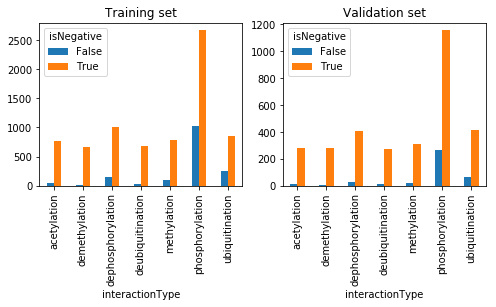

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots( 1,2, figsize=(8,3))

#fig, ax = plt.subplots( 7,1, figsize=(45,30))
train.groupby(['interactionType', 'isNegative']).size().unstack().plot.bar(ax=ax[0])
ax[0].set_title( "Training set")


val.groupby(['interactionType', 'isNegative']).size().unstack().plot.bar(ax=ax[1])
ax[1].set_title( "Validation set")


plt.savefig("NegativeSample.svg",bbox_inches = "tight")
plt.show()

In [40]:
val.groupby(['isNegative', 'interactionType']).size()

isNegative  interactionType  
False       acetylation            14
            demethylation           2
            dephosphorylation      30
            deubiquitination        9
            methylation            17
            phosphorylation       268
            ubiquitination         61
True        acetylation           284
            demethylation         284
            dephosphorylation     404
            deubiquitination      275
            methylation           310
            phosphorylation      1156
            ubiquitination        411
dtype: int64

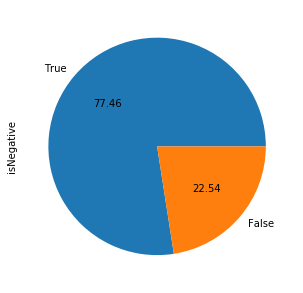

In [50]:
import matplotlib.pyplot as plt
val.isNegative.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.savefig("Interaction.png")

In [42]:
train.to_json("train.json")
test.to_json("test.json")
val.to_json("val.json")

### Train val split such that the pubmedid do not overladp

In [43]:
from sklearn.model_selection import train_test_split
trainpubmed, testpubmed = train_test_split(data_filtered.pubmedId.unique(), test_size=.2,
                                                        random_state=777)

trainpubmed, valpubmed = train_test_split(trainpubmed, test_size=.2,
                                                        random_state=777)

In [44]:
print("Unique pubmeds in train {}, test {} and val {}".format(len(trainpubmed), len(testpubmed),len(valpubmed)))

Unique pubmeds in train 521, test 164 and val 131


In [45]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]



In [46]:

train = generate_negative(train,  annotations_file)
print("The total number of train records including fake records {}".format(train.shape[0]))



test = generate_negative(test,  annotations_file)
print("The total number of test records including fake records {}".format(test.shape[0]))


val = generate_negative(val, annotations_file)
print("The total number of val records including fake records {}".format(val.shape[0]))

The total number of train records including fake records 7261
The total number of test records including fake records 2450
The total number of val records including fake records 1717


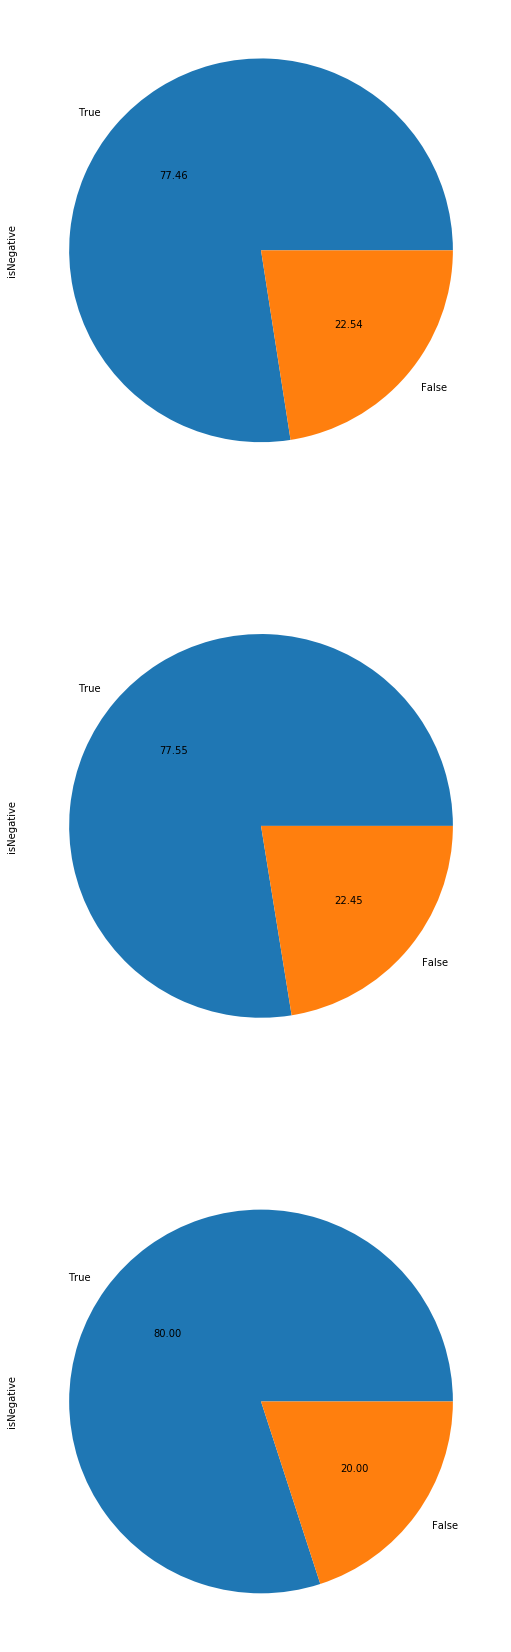

In [47]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots( 3,1, figsize=(50,30))
train.isNegative.value_counts().plot.pie(autopct='%.2f',ax=ax[1])


val.isNegative.value_counts().plot.pie(autopct='%.2f',ax=ax[0])

test.isNegative.value_counts().plot.pie(autopct='%.2f',ax=ax[2])

In [48]:
train.to_json("train_unique_pub.json")
test.to_json("test_unique_pub.json")
val.to_json("val_unique_pub.json")

In [49]:
train.head(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isNegative,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,pubmedId,pubmedTitle,pubmedabstract
0,4,True,1160335_8d8d2388-d4c6-4281-a673-13b5c23b18eb_fake_annot,acetylation,True,True,"[[akt1_human], [RAC-alpha serine/threonine-protein kinase], [AKT1], [PKB], [RAC], [RAC-PK-alpha], [Protein kinase B], [Proto-oncogene c-Akt], [Protein kinase B alpha]]",B7Z5R1,"[[vime_human], [Vimentin], [VIM]]",Q9NTM3,20856200,None,"The PI3K/AKT signaling pathway is aberrant in a wide variety of cancers. Downstream effectors of AKT are involved in survival, growth and metabolic-related pathways. In contrast, contradictory data relating to AKT effects on cell motility and invasion, crucial prometastatic processes, have been reported pointing to a potential cell type and isoform type-specific AKT-driven function. By implication, study of AKT signaling should optimally be conducted in an appropriate intracellular environment. Prognosis in soft-tissue sarcoma (STS), the aggressive malignancies of mesenchymal origin, is poor, reflecting our modest ability to control metastasis, an effort hampered by lack of insight into molecular mechanisms driving STS progression and dissemination. We examined the impact of the cancer progression-relevant AKT pathway on the mesenchymal tumor cell internal milieu. We demonstrate that AKT1 activation induces STS cell motility and invasiveness at least partially through a novel interaction with the intermediate filament vimentin (Vim). The binding of AKT (tail region) to Vim (head region) results in Vim Ser39 phosphorylation enhancing the ability of Vim to induce motility and invasion while protecting Vim from caspase-induced proteolysis. Moreover, vimentin phosphorylation was shown to enhance tumor and metastasis growth in vivo. Insights into this mesenchymal-related molecular mechanism may facilitate the development of critically lacking therapeutic options for these devastating malignancies."
1,4,True,1160335_fc1cf105-2b36-4678-96c4-b9113b2f40da_fake_annot,deubiquitination,True,True,"[[akt1_human], [RAC-alpha serine/threonine-protein kinase], [AKT1], [PKB], [RAC], [RAC-PK-alpha], [Protein kinase B], [Proto-oncogene c-Akt], [Protein kinase B alpha]]",B7Z5R1,"[[vime_human], [Vimentin], [VIM]]",Q9NTM3,20856200,None,"The PI3K/AKT signaling pathway is aberrant in a wide variety of cancers. Downstream effectors of AKT are involved in survival, growth and metabolic-related pathways. In contrast, contradictory data relating to AKT effects on cell motility and invasion, crucial prometastatic processes, have been reported pointing to a potential cell type and isoform type-specific AKT-driven function. By implication, study of AKT signaling should optimally be conducted in an appropriate intracellular environment. Prognosis in soft-tissue sarcoma (STS), the aggressive malignancies of mesenchymal origin, is poor, reflecting our modest ability to control metastasis, an effort hampered by lack of insight into molecular mechanisms driving STS progression and dissemination. We examined the impact of the cancer progression-relevant AKT pathway on the mesenchymal tumor cell internal milieu. We demonstrate that AKT1 activation induces STS cell motility and invasiveness at least partially through a novel interaction with the intermediate filament vimentin (Vim). The binding of AKT (tail region) to Vim (head region) results in Vim Ser39 phosphorylation enhancing the ability of Vim to induce motility and invasion while protecting Vim from caspase-induced proteolysis. Moreover, vimentin phosphorylation was shown to enhance tumor and metastasis growth in vivo. Insights into this mesenchymal-related molecular mechanism may facilitate the development of critically lacking therapeutic options for these devastating malignancies."
2,4,True,1160335_5972a1a1-2098-4f55-b30d-aaf258b83517_fake_annot,dephosphorylation,True,True,"[[akt1_human], [RAC-al